In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> Hand gesture recognition using deep learning can be accomplished by training a convolutional neural network (CNN) on a dataset of hand gesture images. Here, we will walk through the process of setting up a model, training it, and evaluating its performance using TensorFlow and Keras. This will include loading the dataset, applying data augmentation, defining the model architecture, and using callbacks like EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau

### Import Libraries and Setup

First, let's import the necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, Sequential
from glob import glob
import cv2
import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
from keras.preprocessing import image_dataset_from_directory

### IMPORT DATASET

**Hand Gesture Recognition Database** is the dataset used in this project. Hand gesture recognition database is presented, composed by a set of near infrared images acquired by the Leap Motion sensor.

This dataset is freely available on Kaggle.

The database is composed by 10 different hand-gestures (showed above) that were performed by 10 different subjects (5 men and 5 women).

The database is structured in different folders as:

/00 (subject with identifier 00)
/01_palm (images for palm gesture of subject 00 )
/01_palm/frame_197957_r.png,…,frame_198136_l.png, … (images that corresponds to different samples obtained for the palm gesture performed by the subject with identifier 00)
/02_l (images for l gesture of subject 00 )
/10_down
/01
/02
/09 (last subject with identifier 09)
Every root folder (00, 01,…) contains the infrared images of one subject. The folder name is the identifier of each different subject.

In [5]:
img_dir = '/kaggle/input/leapgestrecog/leapGestRecog'


#### Load the dataset and split into training and validation sets

In [12]:
train_data = image_dataset_from_directory(
    img_dir,
    validation_split = 0.25,
    labels = 'inferred',
    subset = 'training',
    seed = 100, 
    image_size = (128,128),
    batch_size = 32
)
val_data = image_dataset_from_directory(
    img_dir,
    validation_split = 0.25,
    subset = 'validation',
    labels = 'inferred',
    seed = 100,
    image_size = (128,128),
    batch_size = 32
)

Found 20000 files belonging to 10 classes.
Using 15000 files for training.
Found 20000 files belonging to 10 classes.
Using 5000 files for validation.


### Data Augmentation

Apply data augmentation to the training dataset to help the model generalize better:

In [14]:
data_augmentation = Sequential([
#     layers.RandomFlip('horizontal_and_vertical'),
#     layers.RandomRotation(0.3),
    layers.RandomZoom(0.2)
])

In [15]:
# Apply the data augmentation to the training dataset
train_data = train_data.map(lambda x, y: (data_augmentation(x, training = True), y))

### EXPLORE the DATASET

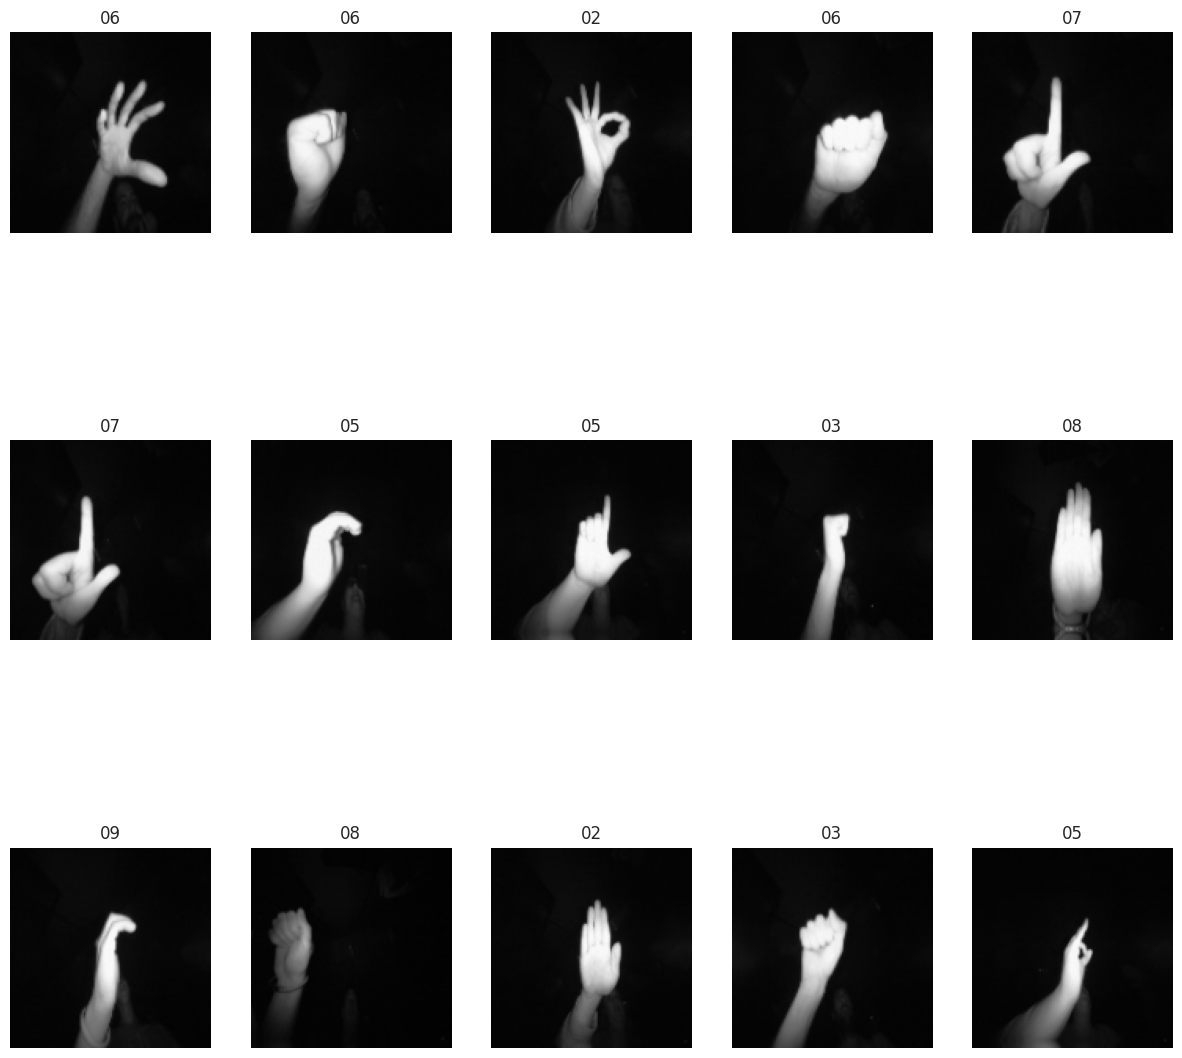

In [16]:
def plot_random_images(dataset, class_names, num_images=15):
    plt.figure(figsize=(15, 15))
    for i, (images, labels) in enumerate(dataset.take(1)):
        # Convert the tensor to numpy array and shuffle
        images = images.numpy()
        labels = labels.numpy()
        indices = np.random.choice(images.shape[0], num_images, replace=False)
        for j, idx in enumerate(indices):
            ax = plt.subplot(3, 5, j + 1)
            plt.imshow(images[idx].astype("uint8"))
            plt.title(class_names[labels[idx]])
            plt.axis("off")
    plt.show()

# Assuming you have class_names available
class_names = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']

# Plot 15 random images from the training dataset
plot_random_images(train_data, class_names)

### Prefetch the datasets for better performance

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size = AUTOTUNE)
val_data = val_data.prefetch(buffer_size = AUTOTUNE)

### Define the Model

Create a CNN model suitable for image classification:

In [18]:
model = Sequential([
    layers.InputLayer(input_shape = (128,128,3)),
    data_augmentation,
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, kernel_size = 3, activation = 'relu', padding = 'same'),
    layers.Dense(128, activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:
model.summary()     # Summarize the model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32, 32, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,566 (16.92 MB)

 Trainable params: 4,371,024 (16.67 MB)

 Non-trainable params: 65,542 (256.02 KB)

#### Model Structue

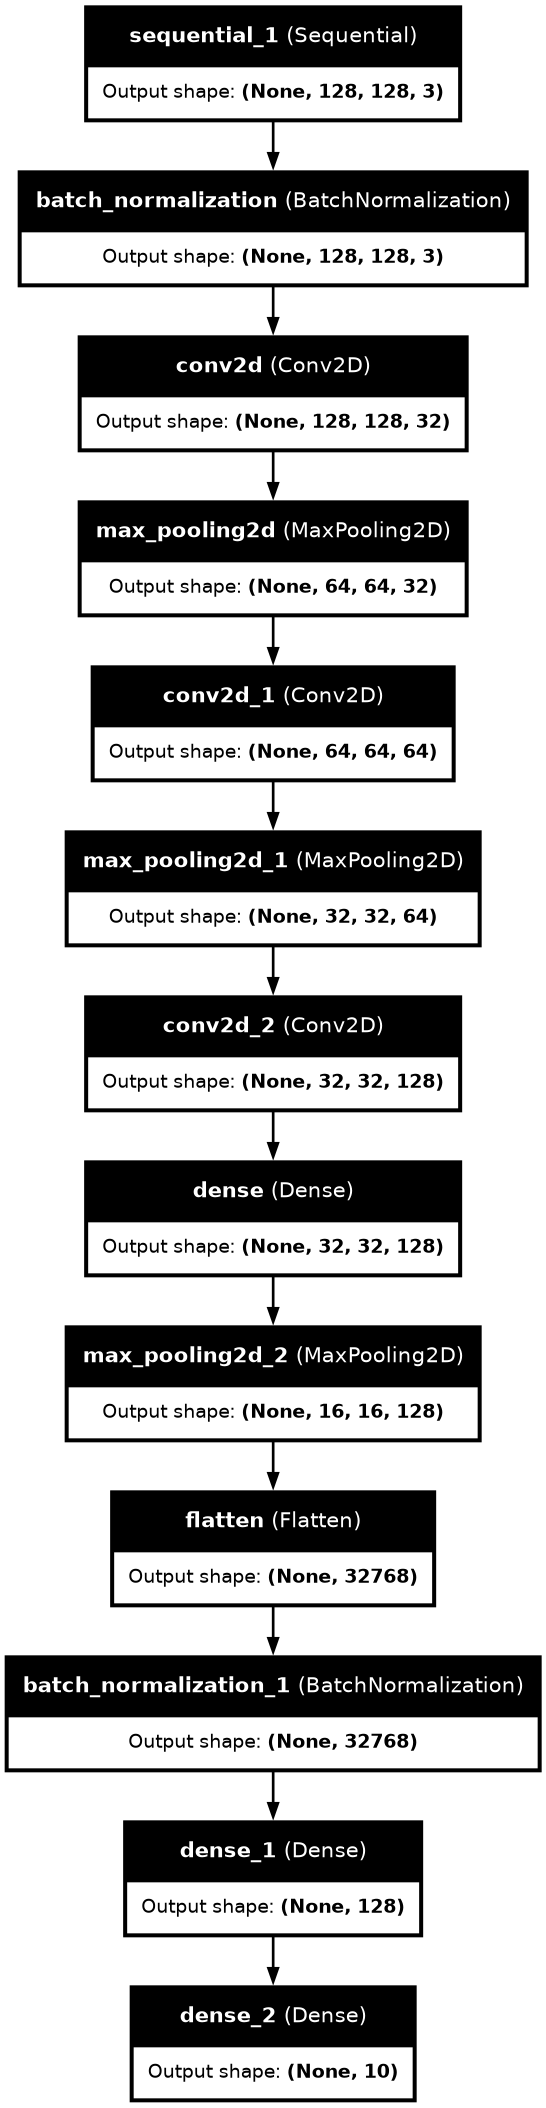

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_structure.png', 
           show_shapes=True, 
           show_layer_names=True, 
           dpi=96, 
           rankdir='TB'
          )

In [20]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

### Setup Callbacks

Define the callbacks for early stopping, saving the best model, and reducing the learning rate on plateau:

In [21]:
earlystopping = EarlyStopping(
    monitor='val_accuracy', 
    min_delta = 0.00001,
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)
reducelr = ReduceLROnPlateau(
    monitor='val_accuracy',    
    factor=0.2,            
    patience=5,            
    verbose=1,             
    min_lr=1e-5            
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

### Train the Model

Train the model using the defined callbacks:

In [22]:
history = model.fit(
    train_data,
    validation_data = val_data, 
    epochs = 20, 
    callbacks = [earlystopping, checkpoint])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8755 - loss: 0.4831
Epoch 1: val_accuracy improved from -inf to 0.87740, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.8756 - loss: 0.4825 - val_accuracy: 0.8774 - val_loss: 0.4282
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9837 - loss: 0.0417
Epoch 2: val_accuracy improved from 0.87740 to 0.92760, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9837 - loss: 0.0418 - val_accuracy: 0.9276 - val_loss: 0.3809
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9762 - loss: 0.0784
Epoch 3: val_accuracy did not improve from 0.92760
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9762 - loss: 0.0784 - val_accuracy: 0.9238 - val_loss: 0.5848
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9825 - loss: 0.0688
Epoch 4: val_accuracy did not improve from 0.92760
469/469 ━━━━━━━━━━

### Evaluate the model 

Evaluate the model on the validation set

In [23]:
val_loss, val_accuracy = model.evaluate(val_data)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", 100*val_accuracy,'%')


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9264 - loss: 0.3756
Validation Loss: 0.38088589906692505
Validation Accuracy: 92.76000261306763 %


As observed, we get an accuracy of about 92.76%

In [26]:
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [27]:
# # Plot training and validation accuracy over epochs
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()